In [1]:
from functions import *
from dateutil.easter import *
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
#for confidence intervalls
from scipy.stats import beta
from scipy import stats
#for fitting of x y data 
from scipy.optimize import curve_fit

# Notebook to develope the prediction pipelines. 

First making the old pipleline selective callable and then adding the delta easter prediction version 1 and first part of delta march

In [2]:
def prepare_input(df,pump=False,end=False,bad_cut=0.9,zero_time=(2015,1,1,0,0),old=False,str_convert=True,version='y_fraction1'):
    #zero time of model can change later
    zero=datetime(zero_time[0],zero_time[1],zero_time[2],zero_time[3],zero_time[4])
    #new column names
    if old==False:
        dic2={'Datum':'Date','Anfang':'Time','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power','Residuallast [MWh] Originalauflösungen':'residual_power','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
        df.rename(columns=dic2,inplace=True)
    else:
        dic1={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'}
        df.rename(columns=dic1,inplace=True)
    #drop columns
    if end==True:
        df.drop(['Ende'], axis=1, inplace=True)
    #cpnvert german float to english 
    if str_convert==True:
        df['residual_power'] = df['residual_power'].str.replace('.','')
        df['residual_power'] = df['residual_power'].str.replace('-','0')
        df['residual_power'] = df['residual_power'].str.replace(',','.').astype(float)/1000.
        df['total_power'] = df['total_power'].str.replace('.','')
        df['total_power'] = df['total_power'].str.replace('-','0')    
        df['total_power'] = df['total_power'].str.replace(',','.').astype(float)/1000.
        if pump==True:
            df['pump_storage'] = df['pump_storage'].str.replace('.','')
            df['pump_storage'] = df['pump_storage'].str.replace(',','.').astype(float)/1000.
    df['date_time']=pd.to_datetime(df['Date'] + '.' + df['Time'], format='%d.%m.%Y.%H:%M')
    delta=str(df.loc[0,'date_time']-zero)
    #deltam=time.strftime(delta,'%M')
    days=delta.split(' days ')
    hour=days[1].split(':')
    #difference in fraction of days
    diff_frac=float(days[0])+float(hour[0])/24+float(hour[1])/24/60
    time1=np.zeros((df.shape[0],5))
    for i in range(df.shape[0]):
        time1[i,0]=diff_frac+i/4/24
        time1[i,1]=time1[i,0]%1
        time1[i,2]=(time1[i,0]%7)/7
        time1[i,3]=(time1[i,0]%365.25)/365.25
        time1[i,4]=i/4/24/365.25      
    df['frac_day']=time1[:,1]
    df['frac_week']=time1[:,2]
    df['frac_year']=time1[:,3]
    #works at least for full days, later more checks 
    #helper parameter used below
    df['year']=df.date_time.dt.year.astype(int)
    df['month']=df.date_time.dt.month.astype(int)
    #days from easter of this year
    df['delta_easter']=0
    #days from first march of the year, gest holidayts right given leap years
    df['delta_march']=0
    #works at least for full days, later more checks 
    for i in range(df.shape[0]):
        df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
        if df.month.iloc[i]<2.5:
            df['delta_march'].iloc[i]=(df['date_time'].iloc[i]-datetime(df['year'].iloc[i]-1,3,1)).days
        else:
            df['delta_march'].iloc[i]=(df['date_time'].iloc[i]-datetime(df['year'].iloc[i],3,1)).days            
    #exclude what is zero at the end
    c=0
    while df.loc[df.shape[0]+c-1,'total_power']==0:
        c-=1
    #interpolate linear bad value (only exatcly 0 for now) which are not at the beginning or end 
    for i in range(1,df.shape[0]+c-2):
        if df.loc[i,'total_power']==0:
            df.loc[i,'total_power']=(df.loc[i-1,'total_power']+df.loc[i+1,'total_power'])/2    
    #return of the the needed columns in the right order, and dleta when last is likely bad
    delta=0                   
    if df.loc[df.shape[0]+c-1,'total_power']/df.loc[df.shape[0]+c-2,'total_power']<bad_cut:
        delta=-1
    #return needed output, order matters    
    if version=='y_fraction1':    
        return df.loc[:df.shape[0]+c-1+delta,['total_power','frac_day', 'frac_week', 'frac_year','date_time']]
    elif version=='d_easter1':    
        return df.loc[:df.shape[0]+c-1+delta,['frac_day','frac_week','delta_easter','total_power','date_time']] 
    elif version=='d_march1':    
        return df.loc[:df.shape[0]+c-1+delta,['frac_day','frac_week','delta_march','total_power','date_time']]    

In [195]:
#plotting function 
def plot_prediction(power_newest,prediction_newest,plot_error=False):
    plt.plot(power_newest['date_time'],(power_newest['total_power']*4),'-',ms=1,color='blue',label='observed')   
    plt.plot(prediction_newest.date_time,prediction_newest.consumption_cleaned,color='red',label='prediction')
    if plot_error==True:
        plt.plot(prediction_newest.date_time,prediction_newest.consumption_cleaned+prediction_newest.error,color='orange',label='1 sigma band')
        plt.plot(prediction_newest.date_time,prediction_newest.consumption_cleaned-prediction_newest.error,color='orange')
    plt.xlabel("date")
    plt.ylabel("consumption [GW]") 
    plt.legend(loc="best")
    plt.title("current prediction")
    max_t=prediction_newest.loc[prediction_newest.shape[0]-1,'date_time']+timedelta(days=1)
    min_t=prediction_newest.loc[prediction_newest.shape[0]-1,'date_time']+timedelta(days=-2)
    year_stop=max_t.year
    month_stop=max_t.month
    day_stop=max_t.day
    year_start=min_t.year
    month_start=min_t.month
    day_start=min_t.day
    plot_start = datetime(year_start, month_start, day_start)
    if plot_error==False:
        min_pred=prediction_newest.consumption_cleaned.min()
        max_pred=prediction_newest.consumption_cleaned.max()
    else:
        min_pred=(prediction_newest.consumption_cleaned-prediction_newest.error).min()
        max_pred=(prediction_newest.consumption_cleaned+prediction_newest.error).max()    
    power_sel=power_newest[(power_newest.date_time==plot_start)]
    min_actual=4*power_newest[power_sel.index[0]:].total_power.min()
    max_actual=4*power_newest[power_sel.index[0]:].total_power.max()
    min_power=min(min_pred,min_actual)
    max_power=max(max_pred,max_actual)
    plt.xlim(datetime(year_start,month_start,day_start),datetime(year_stop,month_stop,day_stop))
    plt.ylim(min_power*0.99,max_power*1.01)

In [196]:
def find_data(end_x='json',data='Realisierter_Stromverbrauch_',myPath='/home/tobias/ml-testing/energy/energy-timeseries',version='y_fraction1'):
    if version=='y_fraction1':
        start_x='xgb_model_'
    if version=='d_easter1':
        start_x='xgb2e_model_'
        errors=np.loadtxt("xgb2e_model_error_offset.txt")
    models=[f for f in os.listdir(myPath) 
        if (f.startswith(start_x)) and  (f.endswith(end_x) )] 
    models.sort()
    data=[f for f in os.listdir(myPath) 
        if (f.startswith(data))]
    data.sort()
    errors=np.loadtxt("xgb2e_model_error_offset.txt")
    if version=='y_fraction1': 
        return models, data
    if version=='d_easter1': 
        return models, data, errors    

Function to clean data now more separated. 

In [218]:
#parameters, most recent features, list of model,delta ts, standard is just every 0.25 h from models, delta, means whether start_time is reduced sometimes also point is bad, like in  Realisierter_Stromverbrauch_202402260600_202403080559_Viertelstunde.csv (residual and pump are missing then could be a sign), now cleaned in input when 10% off from second alst data point, now linear interpolation of point when 4% of for 2 cloest and 2 second closets enighbor is heuristic, also saved now, better (justified) interpolation done at some point, both now saved
def predict_from_now(data,models,errors=None,deltas=None,silent=False,delta=0,version='y_fraction1'):
    if silent==False:    
        print(data)
    if deltas==None:
        deltas=np.zeros((len(models)))
        for i in range(len(models)):
            deltas[i]=0.25+i/4
    #3 error to be added at some point        
    res=np.zeros((3,len(models)))  
    res[0,:]=deltas
    for i in range(len(models)):
        if silent==False:
            print(f"prediction of model {i} dones")
        xmodel=XGBRegressor()
        xmodel.load_model(models[i])
        #predict needs more than 1 data point to work 
        #oldest model no error and nom offset
        if version=='y_fraction1':
            res[1,i]=xmodel.predict(data.iloc[:,0:4])[-1+delta]*4
        #other have     
        elif version=='d_easter1':
            #predict
            pred=xmodel.predict(data.iloc[:,0:4])[-1+delta]
            #use absolute adjustments
            res[1,i]=(pred+errors[2,i])*4   
            res[2,i]=errors[1,i]*4
        elif version=='d_march1':
            pred=xmodel.predict(data.iloc[:,0:4])[-1+delta]
            res[1,i]=(pred+errors[2,i])*4   
            res[2,i]=errors[1,i]*4
    #make data frame 
    df=pd.DataFrame(res.T,columns=['hours','consumption','error'])
    for i in range(df.shape[0]):
        df.loc[i,'date_time']=data.iloc[data.shape[0]-1+delta,data.shape[1]-1]+timedelta(hours=df['hours'][i])
    #also write it that the predictions can be investiagted at some point
    year=data.iloc[data.shape[0]-1+delta,data.shape[1]-1].year
    month=data.iloc[data.shape[0]-1+delta,data.shape[1]-1].month    
    day=data.iloc[data.shape[0]-1+delta,data.shape[1]-1].day   
    hour=data.iloc[data.shape[0]-1+delta,data.shape[1]-1].hour    
    minute=data.iloc[data.shape[0]-1+delta,data.shape[1]-1].minute                   
    return df,year,month,day, hour, minute         

In [219]:
models,data,errors=find_data(version='d_easter1')
#last in list is newest 
new_real=pd.read_csv(data[-1],delimiter=';')
#prepocess including some data cleaning
power_newest=prepare_input(new_real,version='d_easter1')

In [199]:
print(power_newest)

     frac_day  frac_week  delta_easter  total_power           date_time
0    0.208333   0.744048           -19     11.71475 2024-03-12 05:00:00
1    0.218750   0.745536           -19     11.89475 2024-03-12 05:15:00
2    0.229167   0.747024           -19     12.20550 2024-03-12 05:30:00
3    0.239583   0.748512           -19     12.52250 2024-03-12 05:45:00
4    0.250000   0.750000           -19     13.22875 2024-03-12 06:00:00
..        ...        ...           ...          ...                 ...
992  0.541667   0.220238            -9     15.20850 2024-03-22 13:00:00
993  0.552083   0.221726            -9     15.08975 2024-03-22 13:15:00
994  0.562500   0.223214            -9     14.91425 2024-03-22 13:30:00
995  0.572917   0.224702            -9     14.72675 2024-03-22 13:45:00
996  0.583333   0.226190            -9     14.77850 2024-03-22 14:00:00

[997 rows x 5 columns]


In [200]:
#apply prediction
errors=np.loadtxt("xgb2e_model_error_offset.txt")

In [202]:
print(errors.shape)
print(errors[1])

(3, 192)
[0.09163683 0.13960695 0.19922275 0.23923801 0.27296764 0.3094071
 0.31159865 0.33746394 0.35667829 0.37096392 0.39585327 0.42695292
 0.41932266 0.4318388  0.4428286  0.45680599 0.46398948 0.48131915
 0.47619999 0.49173268 0.49438629 0.50267845 0.50516932 0.51068148
 0.5210537  0.53078392 0.53560378 0.52333678 0.53369603 0.53250383
 0.53789044 0.53802904 0.55757376 0.55496484 0.55734966 0.54950714
 0.5561365  0.5666397  0.55968147 0.56853861 0.57269806 0.56798834
 0.57415101 0.57972881 0.57550074 0.57164604 0.57656779 0.57987946
 0.57945037 0.57009384 0.58641199 0.57712899 0.58641724 0.5796858
 0.58833584 0.59575097 0.59739492 0.59563503 0.59331169 0.58859195
 0.59052312 0.59614049 0.6023855  0.59448977 0.5975509  0.60413181
 0.60586359 0.58575669 0.59481513 0.59638613 0.6071725  0.59753183
 0.59609799 0.59596294 0.59831984 0.59724587 0.59284939 0.59417559
 0.58938888 0.58979253 0.58372279 0.58764592 0.57900446 0.57046908
 0.56666263 0.57138158 0.56170701 0.56960668 0.56431233

In [203]:
prediction_newest,y,mo,d,h,mi=predict_from_now(power_newest.loc[power_newest.shape[0]-3:power_newest.shape[0],:],models[:],errors=errors,silent=True,version='d_easter1')
print(prediction_newest)

     hours  consumption     error           date_time
0     0.25    58.641724  0.366547 2024-03-22 14:15:00
1     0.50    58.241730  0.558428 2024-03-22 14:30:00
2     0.75    58.487858  0.796891 2024-03-22 14:45:00
3     1.00    57.766562  0.956952 2024-03-22 15:00:00
4     1.25    56.882683  1.091871 2024-03-22 15:15:00
..     ...          ...       ...                 ...
187  47.00    47.794866  2.467081 2024-03-24 13:00:00
188  47.25    47.330678  2.464601 2024-03-24 13:15:00
189  47.50    47.174308  2.471615 2024-03-24 13:30:00
190  47.75    46.704958  2.505167 2024-03-24 13:45:00
191  48.00    46.636431  2.488463 2024-03-24 14:00:00

[192 rows x 4 columns]


Now new scipy curvefit based one. 

In [204]:
def quadratic(x,a,b,c):
    return a+b*x+c*x**2

In [231]:
def clean_prediction(df,year,month,day, hour, minute,silent=True,mode='linear1',version='y_fraction1',clean_lim=0.04):
    #create now new cleaned column 
    #df['consumption_cleaned']=df['consumption']
    if mode=='linear1':
        for i in range(df.shape[0]):
            if i>=2 and i<df.shape[0]-2:            
               #only correct when larger x for neighbor interpolation of 2 clest and 2 second closest neighbors
               if np.abs(df.loc[i,'consumption']-df.loc[i-2,'consumption']/2-df.loc[i+2,'consumption']/2)/(df.loc[i-2,'consumption']/2+df.loc[i+2,'consumption']/2)>clean_lim  and np.abs(df.loc[i,'consumption']-df.loc[i-1,'consumption']/2-df.loc[i+1,'consumption']/2)/(df.loc[i-1,'consumption']/2+df.loc[i+1,'consumption']/2)>clean_lim:
                    df.loc[i,'consumption_cleaned']=(df.loc[i-1,'consumption']+df.loc[i+1,'consumption'])/2  
                    if silent==False:
                        print(f"{i} is cleaned")
               else:   
                    df.loc[i,'consumption_cleaned']=df.loc[i,'consumption']
            else:   
                df.loc[i,'consumption_cleaned']=df.loc[i,'consumption']        
    elif mode=='quadratic1':
        for i in range(df.shape[0]):
            if i>=2 and i<df.shape[0]-2:
                err=np.zeros((4,5))
                err[0]=[-2.,-1.,0.,1.,2.]
                err[1]=df.loc[i-2:i+2,'consumption']
                if version=='y_fraction1':
                    #set one set the scipy below workds
                    err[2]=1.
                    err[3]=1.
                else:    
                    err[2]=df.loc[i-2:i+2,'error']
                    err[3]=df.loc[i-2:i+2,'error']
                x2=0
                for j in range(5):
                    x=i-2+j-2
                    y=i+2+j+2
                    if x>=0 and y<df.shape[0]:
                        if np.abs(df.loc[i+j-2,'consumption']-df.loc[i-2+j-2,'consumption']/2-df.loc[i+2+j-2,'consumption']/2)/(df.loc[i-2+j-2,'consumption']/2+df.loc[i+2+j-2,'consumption']/2)>clean_lim  and np.abs(df.loc[i+j-2,'consumption']-df.loc[i-1+j-2,'consumption']/2-df.loc[i+1+j-2,'consumption']/2)/(df.loc[i-1+j-2,'consumption']/2+df.loc[i+1+j-2,'consumption']/2)>clean_lim:
                            #error is increased by factor 10, means in practice irrelevant easier then remove it
                            err[3,j]=err[2,j]*10
                            x2=2
                            if silent==False:
                                print(f"{i} is error  increased")
                                print(err)
                est=np.zeros((3))
                val,cov=sp.optimize.curve_fit(quadratic,err[0],err[1],sigma=err[3],absolute_sigma=True,p0=est)
                df.loc[i,'consumption_cleaned']=val[0]
                if silent==False and x2==2:
                    print(df.loc[i,'consumption_cleaned'])
            else:
                df.loc[i,'consumption_cleaned']=df.loc[i,'consumption']
                
    df.to_csv(version+'_prediction_'+str(year)+'_'+str(month)+'_'+str(day)+'_'+str(hour)+'_'+str(minute)+'.csv',sep=',') 
    return df

In [232]:
#problem was data frame was not copied 
prediction_newest3=clean_prediction(prediction_newest.copy(),y,mo,d,h,mi,version='d_easter1',silent=False,mode='linear1')
print(prediction_newest3)

57 is cleaned
     hours  consumption     error           date_time  consumption_cleaned
0     0.25    58.641724  0.366547 2024-03-22 14:15:00            58.641724
1     0.50    58.241730  0.558428 2024-03-22 14:30:00            58.241730
2     0.75    58.487858  0.796891 2024-03-22 14:45:00            58.487858
3     1.00    57.766562  0.956952 2024-03-22 15:00:00            57.766562
4     1.25    56.882683  1.091871 2024-03-22 15:15:00            56.882683
..     ...          ...       ...                 ...                  ...
187  47.00    47.794866  2.467081 2024-03-24 13:00:00            47.794866
188  47.25    47.330678  2.464601 2024-03-24 13:15:00            47.330678
189  47.50    47.174308  2.471615 2024-03-24 13:30:00            47.174308
190  47.75    46.704958  2.505167 2024-03-24 13:45:00            46.704958
191  48.00    46.636431  2.488463 2024-03-24 14:00:00            46.636431

[192 rows x 5 columns]


In [233]:
print(prediction_newest3)
prediction_newest2=clean_prediction(prediction_newest.copy(),y,mo,d,h,mi,version='d_easter1',silent=False,mode='quadratic1')
print(prediction_newest2)
print(prediction_newest3)

     hours  consumption     error           date_time  consumption_cleaned
0     0.25    58.641724  0.366547 2024-03-22 14:15:00            58.641724
1     0.50    58.241730  0.558428 2024-03-22 14:30:00            58.241730
2     0.75    58.487858  0.796891 2024-03-22 14:45:00            58.487858
3     1.00    57.766562  0.956952 2024-03-22 15:00:00            57.766562
4     1.25    56.882683  1.091871 2024-03-22 15:15:00            56.882683
..     ...          ...       ...                 ...                  ...
187  47.00    47.794866  2.467081 2024-03-24 13:00:00            47.794866
188  47.25    47.330678  2.464601 2024-03-24 13:15:00            47.330678
189  47.50    47.174308  2.471615 2024-03-24 13:30:00            47.174308
190  47.75    46.704958  2.505167 2024-03-24 13:45:00            46.704958
191  48.00    46.636431  2.488463 2024-03-24 14:00:00            46.636431

[192 rows x 5 columns]
55 is error  increased
[[-2.         -1.          0.          1.          2.

0     0.000000
1     0.000000
2     0.316815
3    -0.085766
4    -0.165840
5     0.125209
6     0.017679
7    -0.156489
8     0.123532
9     0.202297
10   -0.428389
11    0.299397
12   -0.160936
13    0.192287
14   -0.104610
15   -0.345037
16    0.782216
17   -0.498869
18   -0.262923
19    0.651606
Name: consumption_cleaned, dtype: float64
   hours  consumption     error           date_time  consumption_cleaned
0   0.25    58.641724  0.366547 2024-03-22 14:15:00            58.641724
1   0.50    58.241730  0.558428 2024-03-22 14:30:00            58.241730
2   0.75    58.487858  0.796891 2024-03-22 14:45:00            58.487858
3   1.00    57.766562  0.956952 2024-03-22 15:00:00            57.766562
4   1.25    56.882683  1.091871 2024-03-22 15:15:00            56.882683
5   1.50    56.782490  1.237628 2024-03-22 15:30:00            56.782490
6   1.75    56.529510  1.246395 2024-03-22 15:45:00            56.529510
7   2.00    56.368649  1.349856 2024-03-22 16:00:00            56.368649
8

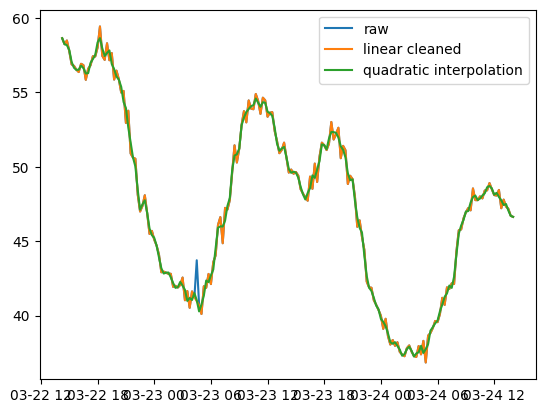

In [225]:
plt.plot(prediction_newest.date_time,prediction_newest2.consumption,label='raw')
plt.plot(prediction_newest.date_time,prediction_newest3.consumption_cleaned,label='linear cleaned')
plt.plot(prediction_newest.date_time,prediction_newest2.consumption_cleaned,label='quadratic interpolation')
#plt.plot(prediction_newest.date_time,prediction_newest3.consumption,label='raw2')
plt.legend()
print((prediction_newest3.consumption_cleaned-prediction_newest2.consumption_cleaned).iloc[0:20])
print(prediction_newest3.iloc[0:10,:])
print(prediction_newest2.iloc[0:10,:])

Less wiggles now

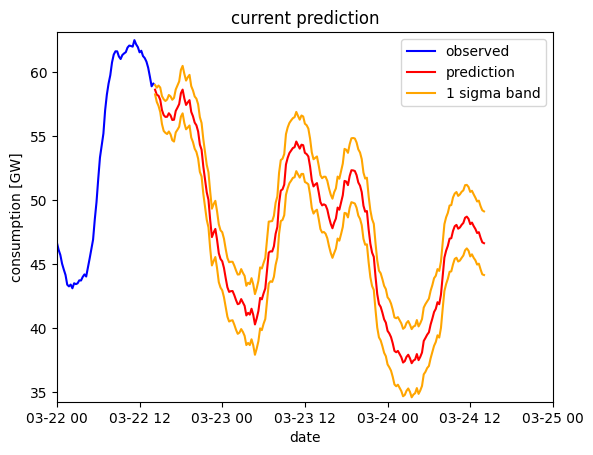

In [226]:
#plot prediction
plot_prediction(power_newest.iloc[:,:],prediction_newest2,plot_error=True)

Looks now good. (Errors should become a true band at some point.)

Past function works for past mode. 

In [240]:
#parameter, version of models, whetehr process is printed, whether error is used in Figure
def pipeline(version='y_fraction1',silent=True,plot_error=False,mode='linear1'):
    #get model and data file lists
    if version=='y_fraction1':
        models,data=find_data(version=version)
        #create dummy errors to simplyfy prediction below
        errors=np.zeros((3,len(models)))
        #create non zero error to avoid error problem
        errors[1]=1.
    if version=='d_easter1':
        models,data,errors=find_data(version=version)   
    #also error/offset file if exist    
    #last in list is newest 
    new_real=pd.read_csv(data[-1],delimiter=';')
    #prepocess including some data cleaning
    power_newest=prepare_input(new_real,version=version)
    #apply prediction
    prediction_newest,y,mo,d,h,mi=predict_from_now(power_newest.loc[power_newest.shape[0]-3:power_newest.shape[0],:],models[:],errors,silent=silent,version=version)
    #clean prediction
    prediction_newest=clean_prediction(prediction_newest,y,mo,d,h,mi,silent=silent,mode=mode)
    #plot prediction
    plot_prediction(power_newest.iloc[:,:],prediction_newest,plot_error=plot_error)

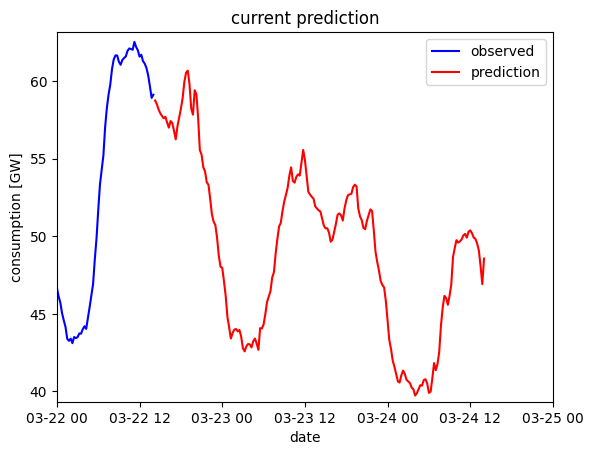

In [241]:
pipeline(silent=True,mode='quadratic1')

Also works in pipeline function with old model. (error is on line as it should be)

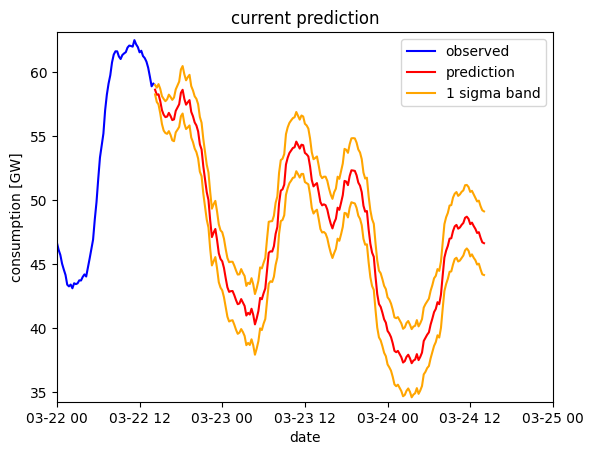

In [242]:
pipeline(plot_error=True,version='d_easter1',mode='quadratic1')

Works now also also with errors. 

In [243]:
#now hidden parameters for d_easter1 model 
#parameter, version of models, whetehr process is printed, whether error is used in Figure
def pipeline_v2(version='d_easter1',silent=True,plot_error=False,mode='quadratic1'):
    #get model and data file lists
    if version=='y_fraction1':
        models,data=find_data(version=version)
        #create dummy errors to simplyfy prediction below
        errors=np.zeros((3,len(models)))
        #create non zero error to avoid error problem
        errors[1]=1.
    if version=='d_easter1':
        models,data,errors=find_data(version=version)   
    #also error/offset file if exist    
    #last in list is newest 
    new_real=pd.read_csv(data[-1],delimiter=';')
    #prepocess including some data cleaning
    power_newest=prepare_input(new_real,version=version)
    #apply prediction
    prediction_newest,y,mo,d,h,mi=predict_from_now(power_newest.loc[power_newest.shape[0]-3:power_newest.shape[0],:],models[:],errors,silent=silent,version=version)
    #clean prediction
    prediction_newest=clean_prediction(prediction_newest,y,mo,d,h,mi,silent=silent,mode=mode)
    #plot prediction
    plot_prediction(power_newest.iloc[:,:],prediction_newest,plot_error=plot_error)

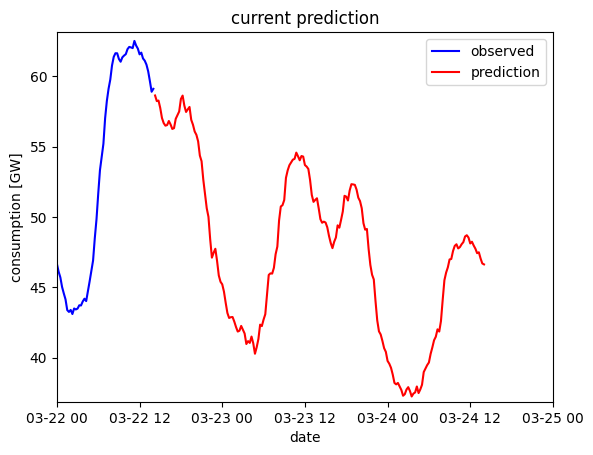

In [244]:
pipeline_v2()

For previous model.

In [246]:
#now hidden parameters for y_fraction1 model 
#parameter, version of models, whetehr process is printed, whether error is used in Figure
def pipeline_v1(version='y_fraction1',silent=True,plot_error=False,mode='quadratic1'):
    #get model and data file lists
    if version=='y_fraction1':
        models,data=find_data(version=version)
        #create dummy errors to simplyfy prediction below
        errors=np.zeros((3,len(models)))
        #create non zero error to avoid error problem
        errors[1]=1.
    if version=='d_easter1':
        models,data,errors=find_data(version=version)   
    #also error/offset file if exist    
    #last in list is newest 
    new_real=pd.read_csv(data[-1],delimiter=';')
    #prepocess including some data cleaning
    power_newest=prepare_input(new_real,version=version)
    #apply prediction
    prediction_newest,y,mo,d,h,mi=predict_from_now(power_newest.loc[power_newest.shape[0]-3:power_newest.shape[0],:],models[:],errors,silent=silent,version=version)
    #clean prediction
    prediction_newest=clean_prediction(prediction_newest,y,mo,d,h,mi,silent=silent,mode=mode)
    #plot prediction
    plot_prediction(power_newest.iloc[:,:],prediction_newest,plot_error=plot_error)

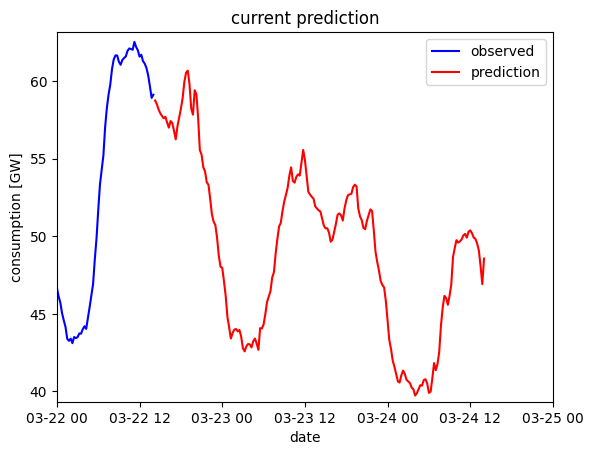

In [247]:
pipeline_v1()

## Conclusions

- All done of previous model plus some improvem,ents
- could use different delta time for prediction since 24 prediction is better than surrounding models. 
- Maybe flux ration compared to last is better also than absolute flux, would to implement that needs more models. 
- The 24 h/48 h ;ag should also be used more in other fitting models